In [29]:
import datetime
import time

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import notebook_libs.utilities as util
import notebook_libs.prometheus as prom

# Experiment in Progress - Client Data

Updated 2023-02-26 16:45:11.456507
in-progress
count    4918.000000
mean      730.442617
std       180.439442
min       505.428076
25%       636.523068
50%       681.099892
75%       769.446671
max      2162.876368
Name: client_latency_ms, dtype: float64



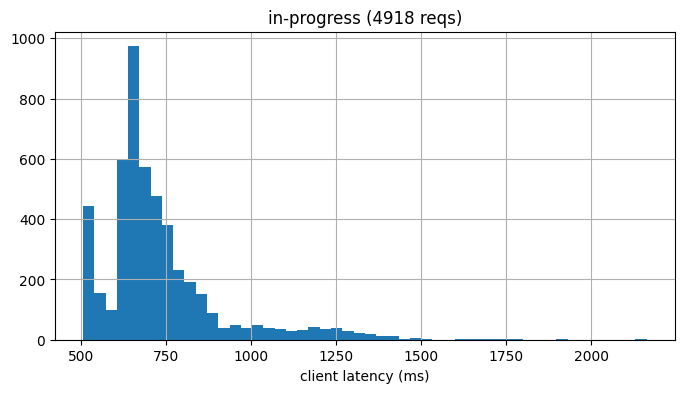

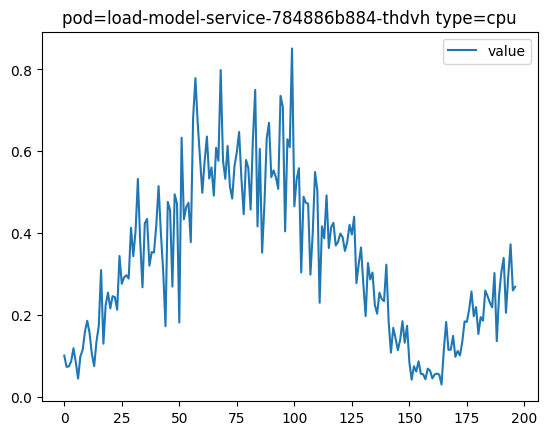

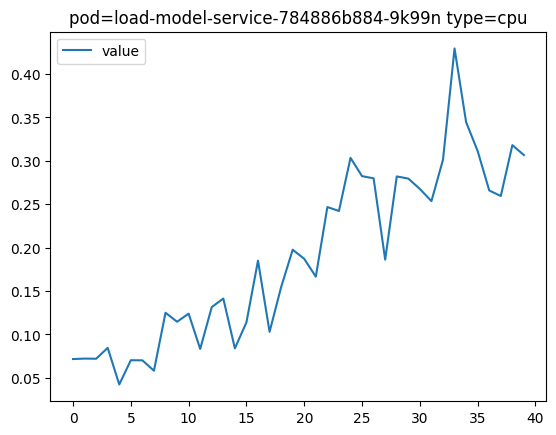

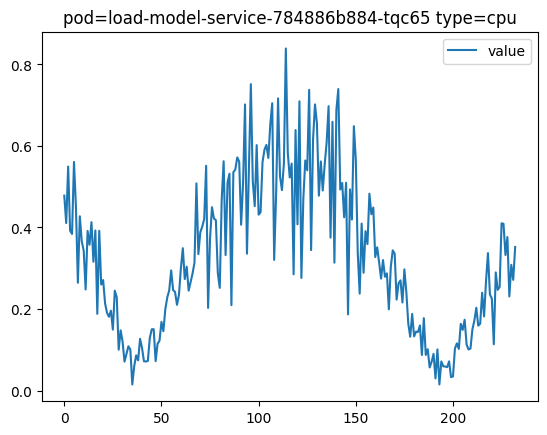

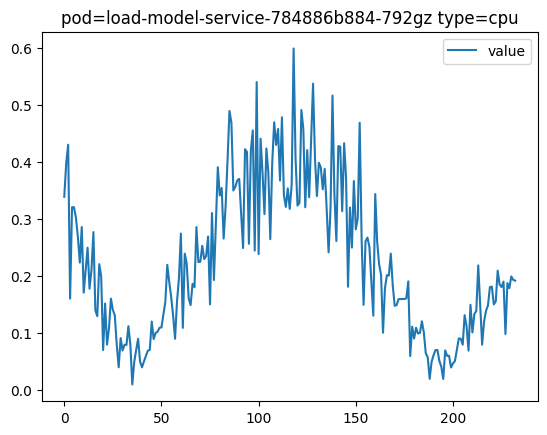

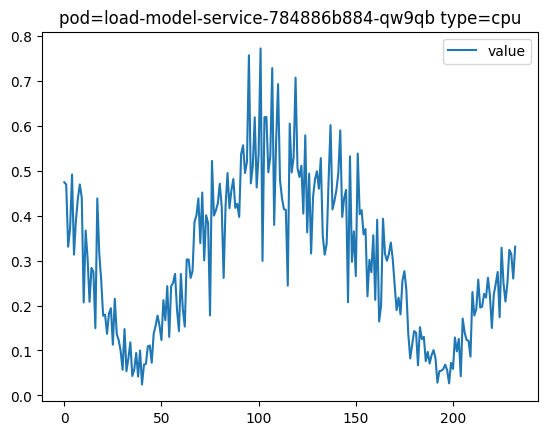

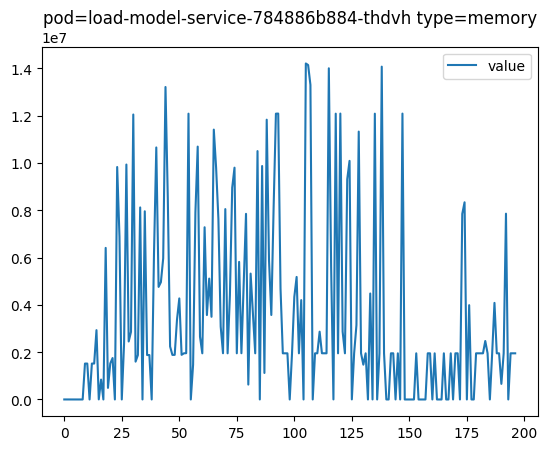

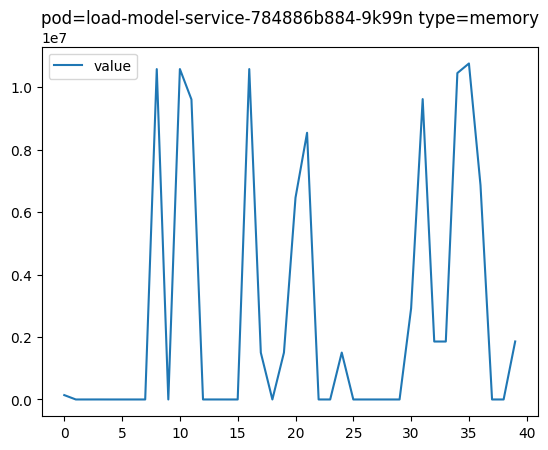

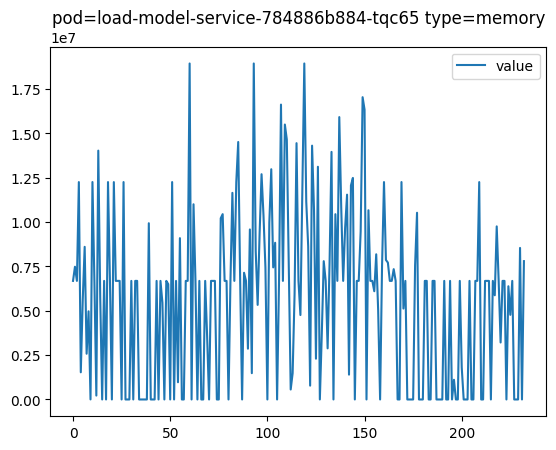

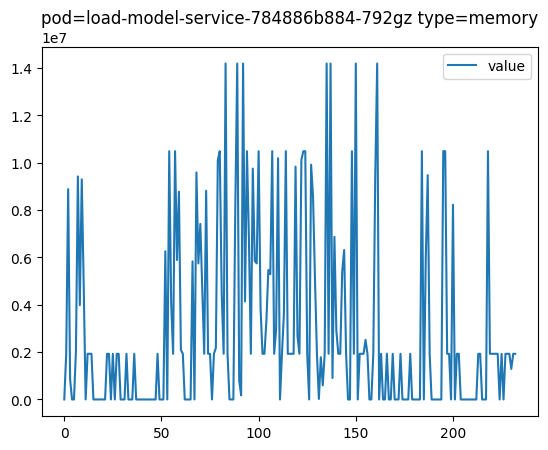

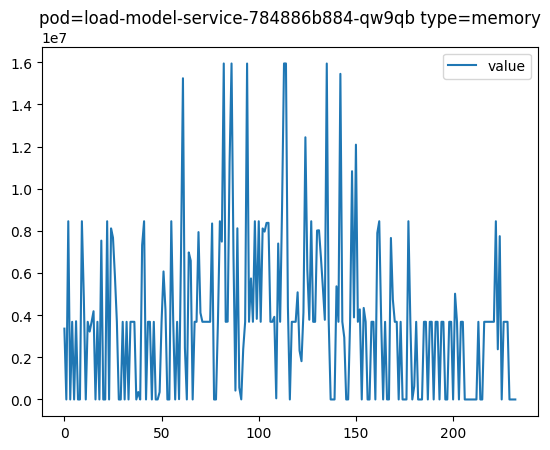

In [30]:
print(f"Updated {datetime.datetime.now()}")
df = util.read_client_requests_in_progress()
f, ax = plt.subplots(figsize=[8,4])
util.plot_client_latency_distribution(df, "in-progress", ax)
plt.show()
result = prom.fetch_experiment_pod_data(int(14000/60.))
util.plot_pod_metrics(result)
plt.show()

# Completed Experiments

In [31]:
print("\n".join([f"{i}: {x}" for i, x in enumerate(util.experiments)]))

0: 2023-02-17_3-replicas
1: 2023-02-17_4-replicas
2: 2023-02-17_5-replicas
3: 2023-02-19_2-replicas
4: 2023-02-18_3-replicas
5: 2023-02-19_4-replicas
6: 2023-02-20_5-replicas
7: 2023-02-24_2-replicas
8: 2023-02-24_3-replicas
9: 2023-02-24_4-replicas
10: 2023-02-24_5-replicas
11: 2023-02-24_6-replicas
12: 2023-02-25_2-replicas
13: 2023-02-25_3-replicas
14: 2023-02-25_4-replicas
15: 2023-02-25_5-replicas
16: 2023-02-25_6-replicas


In [32]:
current_experiment = util.experiments[16]

## 1-Minute buckets for client request data

<Axes: title={'center': 'Client Metrics (1Min Buckets)'}, xlabel='bucket_1_min'>

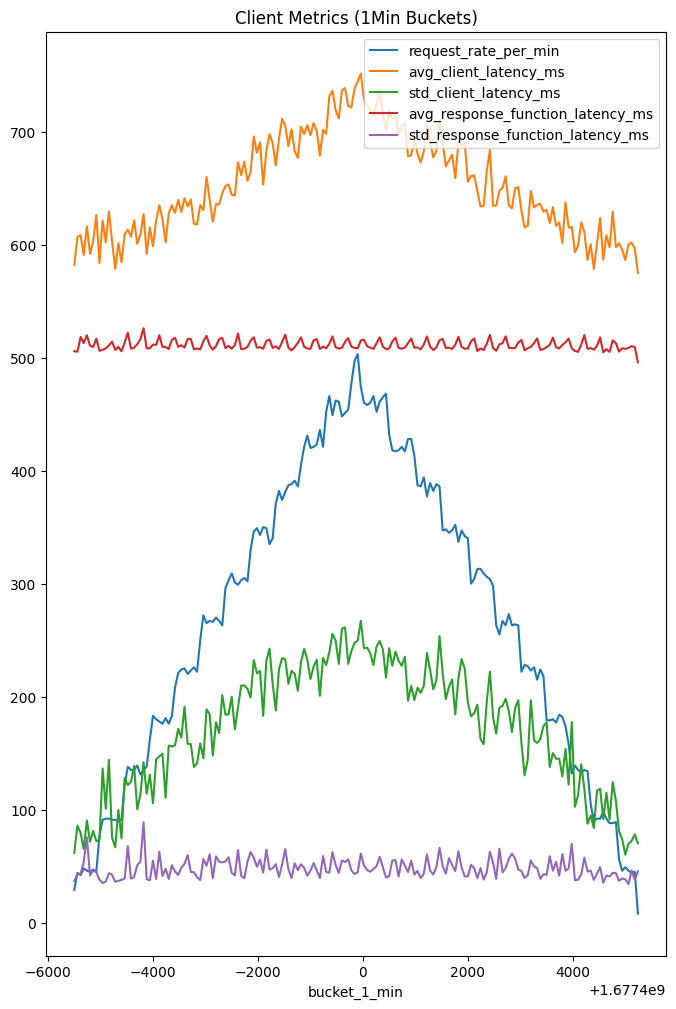

In [33]:
df, first_request_time, final_request_time = util.read_client_requests(current_experiment)
df_bucket = util.create_1_min_bucket_client_metrics(df)
df_bucket.plot(y=[
    "request_rate_per_min", 
    "avg_client_latency_ms",
    "std_client_latency_ms",
    "avg_response_function_latency_ms",
    "std_response_function_latency_ms"
]
,figsize=[8,12]
,title="Client Metrics (1Min Buckets)")

## Compare a Group of Experiments

['2023-02-17_3-replicas', '2023-02-17_4-replicas', '2023-02-17_5-replicas', '2023-02-19_2-replicas', '2023-02-18_3-replicas', '2023-02-19_4-replicas', '2023-02-20_5-replicas', '2023-02-24_2-replicas', '2023-02-24_3-replicas', '2023-02-24_4-replicas', '2023-02-24_5-replicas', '2023-02-24_6-replicas', '2023-02-25_2-replicas', '2023-02-25_3-replicas', '2023-02-25_4-replicas', '2023-02-25_5-replicas', '2023-02-25_6-replicas']
2023-02-17_3-replicas
count    59995.000000
mean      1173.349972
std        481.660493
min        507.251978
25%        767.608285
50%       1112.864017
75%       1501.094460
max       3441.249847
Name: client_latency_ms, dtype: float64

2023-02-17_4-replicas
count    59998.000000
mean       842.603558
std        294.477399
min        497.415066
25%        575.165749
50%        783.455968
75%       1030.104816
max       2526.618719
Name: client_latency_ms, dtype: float64

2023-02-17_5-replicas
count    59998.000000
mean       745.289115
std        247.546582
min     

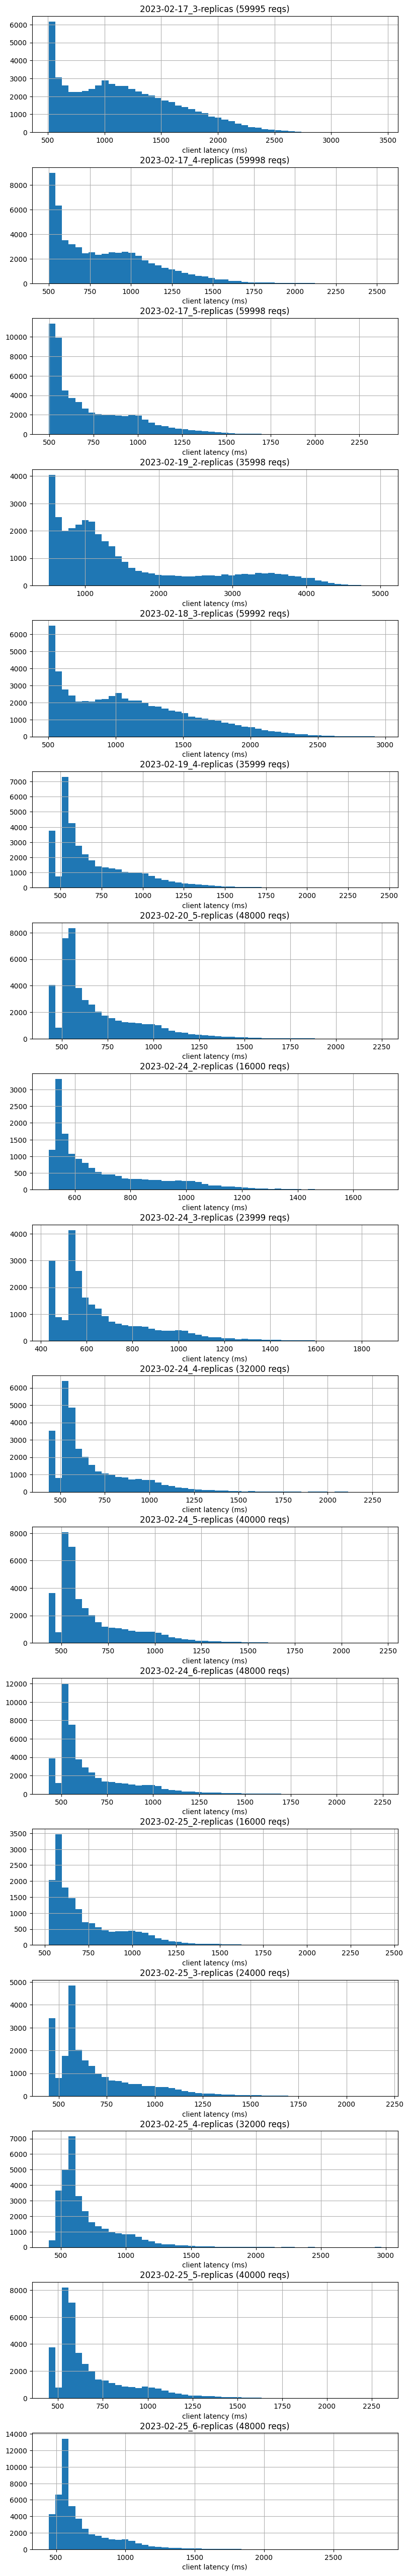

In [34]:
print(util.experiments)
util.compare_client_latency_distributions()

## Experiment Complete - Compare data window between Client and Prometheus

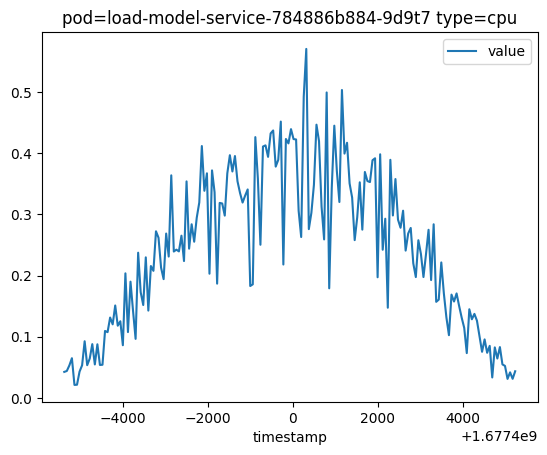

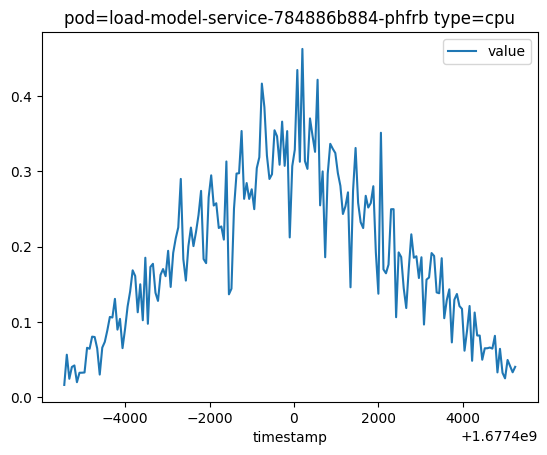

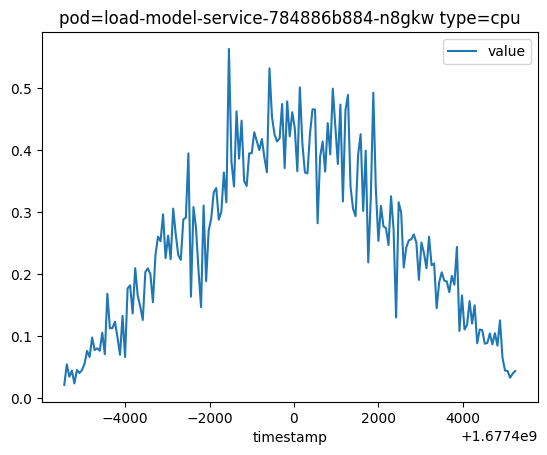

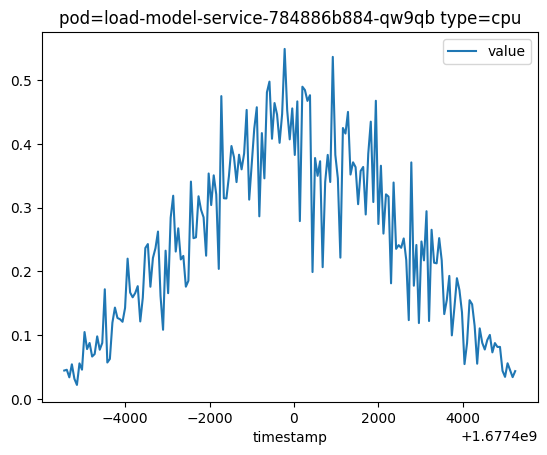

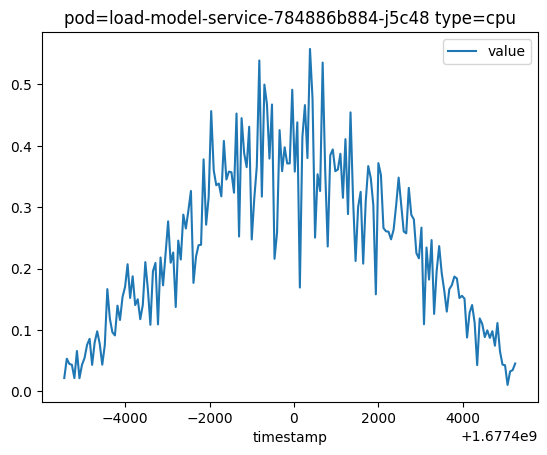

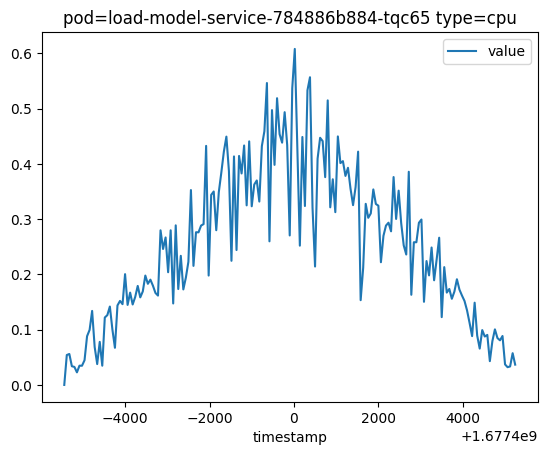

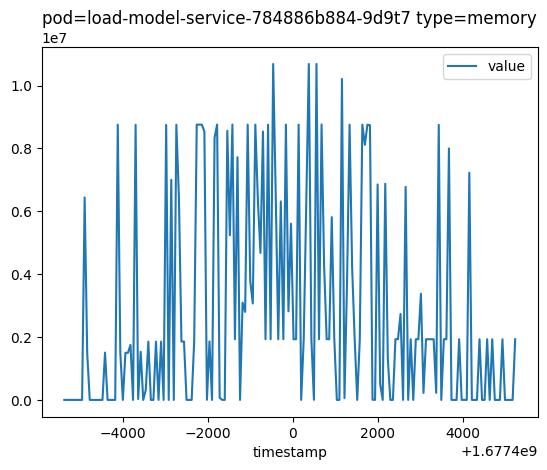

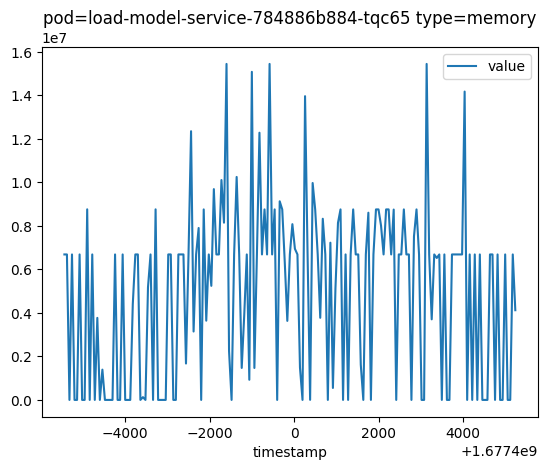

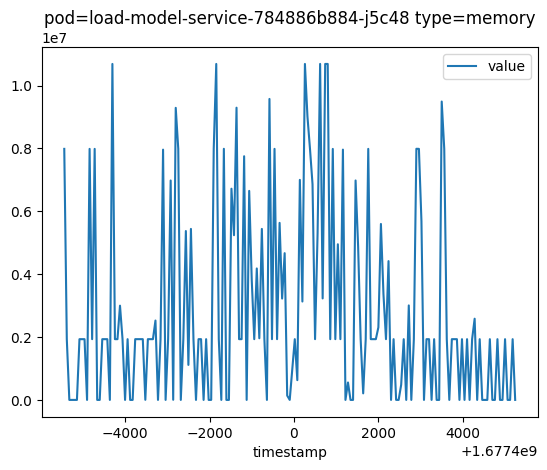

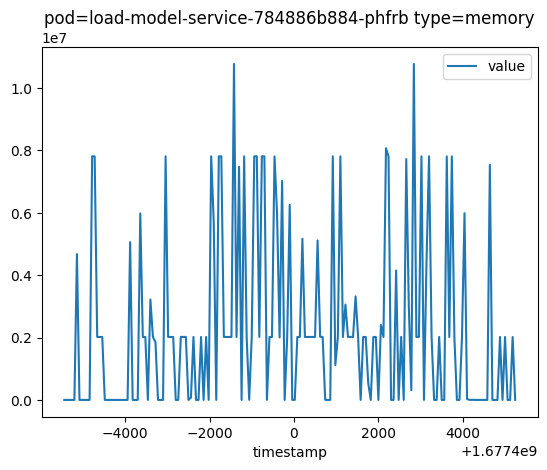

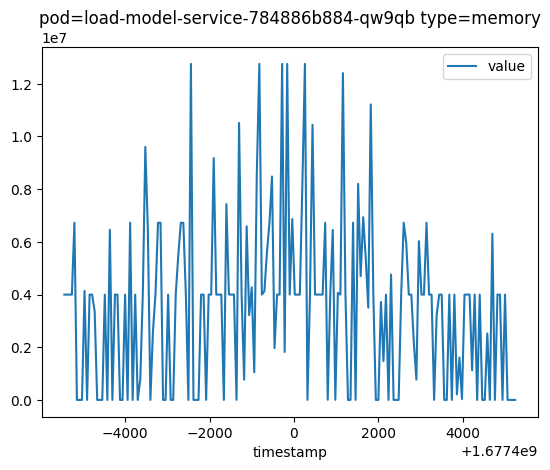

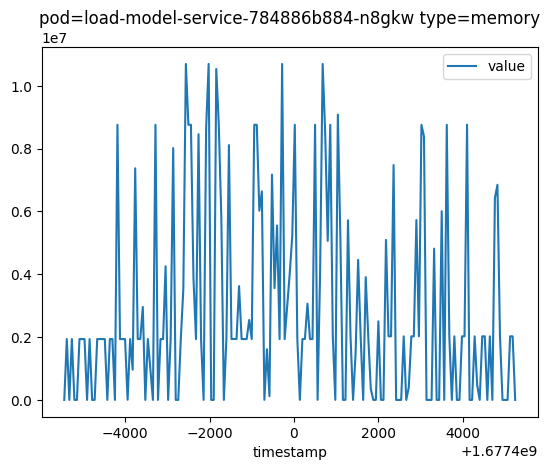

In [35]:
df_pod = util.read_pod_df_list(current_experiment, first_request_time, final_request_time)
util.plot_pod_metrics(df_pod)

In [36]:
df = util.combined_data_set(current_experiment)
df.head(10)

,memory,cpu,request_rate_per_min,avg_client_latency_ms,std_client_latency_ms,avg_response_function_latency_ms,std_response_function_latency_ms,avg_response_memory_usage_mb,std_response_memory_usage_mb,avg_response_load_time_ms,std_response_load_time_ms,replicas
timestamp,,,,,,,,,,,,
1677394560,3.733999e+06,0.020714,44,606.764680,85.903305,505.163074,42.814601,291.847745,1.863902,42.045864,7.390514,6
1677394620,2.425628e+06,0.051029,42,608.339162,79.430338,518.288294,43.009894,291.603330,1.786046,43.080608,7.529713,6
1677394680,6.663737e+05,0.039544,48,590.800251,65.158848,512.757977,53.799429,291.803223,1.800330,41.675647,6.939613,6
1677394740,2.103364e+06,0.044815,46,616.081383,90.303362,519.772970,75.393464,291.562245,1.804027,43.515128,7.303218,6
1677394800,1.120752e+06,0.036057,45,591.871103,71.546867,510.486311,41.874082,291.749566,1.830853,42.271021,6.968383,6
1677394860,7.797159e+05,0.032771,47,602.725217,81.219990,509.385170,46.120246,291.675864,1.781156,42.436579,7.037066,6
1677394920,1.759278e+06,0.034371,45,626.108456,71.983623,516.727951,44.581975,291.692448,1.815187,42.344183,7.124157,6
1677394980,6.449152e+05,0.040740,77,583.533402,73.242515,505.991765,37.973396,291.666548,1.791729,42.564219,7.296713,6
1677395040,1.333975e+06,0.057560,91,621.266373,136.435561,506.840798,34.938146,291.764037,1.804656,42.142617,7.129551,6


<Axes: xlabel='request_rate_per_min', ylabel='memory'>

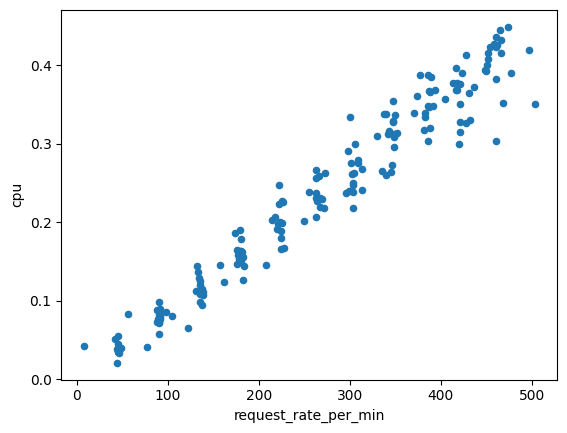

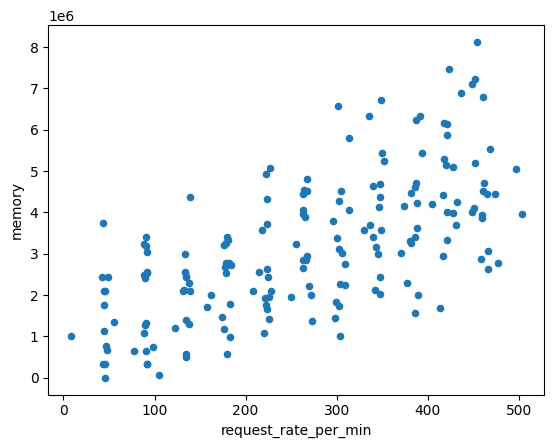

In [37]:
df.plot.scatter(x="request_rate_per_min",y="cpu")
df.plot.scatter(x="request_rate_per_min",y="memory")

# Workload Response Model

In [38]:
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [39]:
df = util.combined_data_sets()
print(df.head(4))

                  memory       cpu  request_rate_per_min  \
timestamp                                                  
1676685600  4.551111e+01  0.007186                  49.0   
1676685660  2.226540e+06  0.068497                  46.0   
1676685720  6.900213e+06  0.079064                  48.0   
1676685780  1.755182e+06  0.098106                  45.0   

            avg_client_latency_ms  std_client_latency_ms  \
timestamp                                                  
1676685600             574.022405              58.230970   
1676685660             609.304216              68.931421   
1676685720             608.947660              74.371525   
1676685780             594.807487              76.878553   

            avg_response_function_latency_ms  \
timestamp                                      
1676685600                        502.168101   
1676685660                        516.961036   
1676685720                        525.960113   
1676685780                        510.

<Axes: title={'center': 'avg_client_latency_ms'}, xlabel='replicas'>

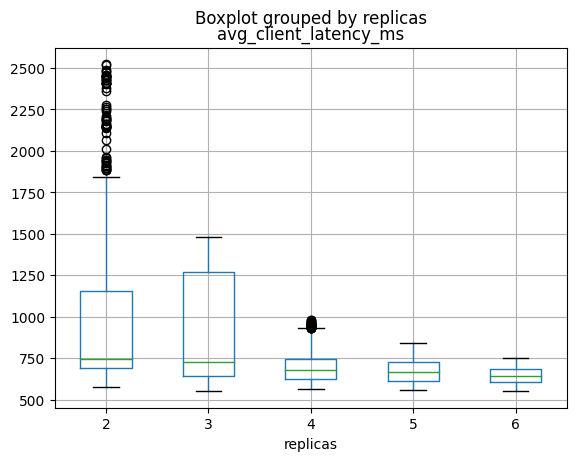

In [40]:
df.boxplot("avg_client_latency_ms", by="replicas")

<Axes: title={'center': 'avg_client_latency_ms'}, xlabel='log_req_rate'>

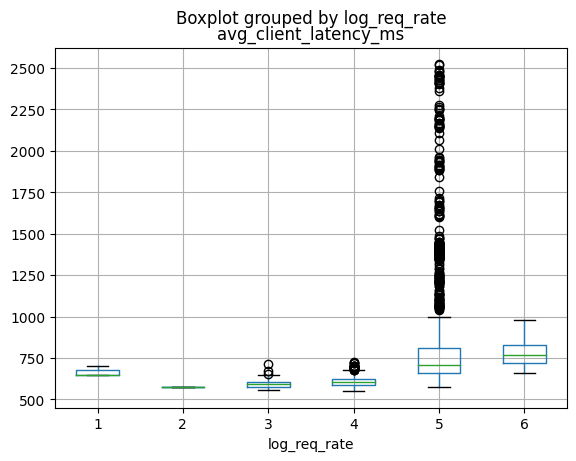

In [41]:
df["log_req_rate"] = df["request_rate_per_min"].apply(lambda x: int(np.log(x)))
df.boxplot("avg_client_latency_ms", by="log_req_rate")

<Axes: title={'center': 'avg_client_latency_ms'}, xlabel='log_memory'>

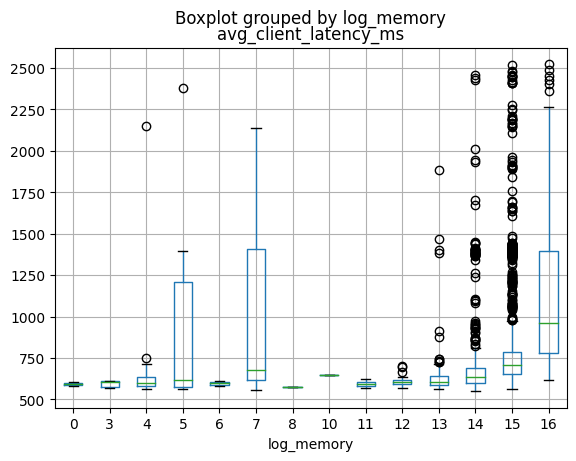

In [42]:
df["log_memory"] = df.memory.apply(lambda x: int(np.log(x+1)))
df.boxplot("avg_client_latency_ms", by="log_memory")

<Axes: title={'center': 'avg_client_latency_ms'}, xlabel='log_cpu'>

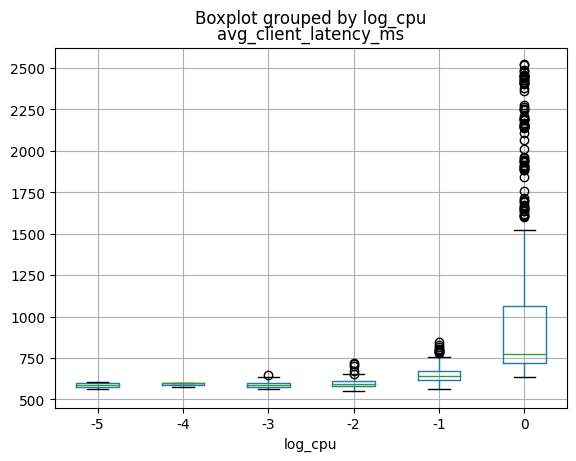

In [43]:
df["log_cpu"] = df.cpu.apply(lambda x: int(np.log(x)))
df.boxplot("avg_client_latency_ms", by="log_cpu")

In [44]:
df_train = df[[ "memory", "cpu", "request_rate_per_min", "avg_client_latency_ms", "replicas"]].copy()
df_train["avg_client_latency_ms"] = df_train["avg_client_latency_ms"].apply(lambda x: np.log(x))

In [45]:
scaler.fit(df_train)
scaled = scaler.transform(df_train)
X = scaled[:,[2,4]]
y = scaled[:,[0,1,3]]

In [46]:
model = Sequential()
model.add(Dense(10, input_shape=(2,), activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(3, activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=165, batch_size=10)

# evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/165
272/272 [==============================] - 1s 777us/step - loss: 0.0283 - accuracy: 0.6244
Epoch 2/165
272/272 [==============================] - 0s 935us/step - loss: 0.0152 - accuracy: 0.6940
Epoch 3/165
272/272 [==============================] - 0s 1ms/step - loss: 0.0142 - accuracy: 0.7147
Epoch 4/165
272/272 [==============================] - 0s 822us/step - loss: 0.0137 - accuracy: 0.7158
Epoch 5/165
272/272 [==============================] - 0s 770us/step - loss: 0.0133 - accuracy: 0.7213
Epoch 6/165
272/272 [==============================] - 0s 884us/step - loss: 0.0127 - accuracy: 0.7261
Epoch 7/165
272/272 [==============================] - 0s 804us/step - loss: 0.0122 - accuracy: 0.7268
Epoch 8/165
272/272 [==============================] - 0s 819us/step - loss: 0.0118 - accuracy: 0.7172
Epoch 9/165
272/272 [==============================] - 0s 773us/step - loss: 0.0115 - accuracy: 0.7202
Epoch 10/165
272/272 [==============================] - 0s 771us/step - los

272/272 [==============================] - 0s 856us/step - loss: 0.0088 - accuracy: 0.7279
Epoch 80/165
272/272 [==============================] - 0s 797us/step - loss: 0.0087 - accuracy: 0.7286
Epoch 81/165
272/272 [==============================] - 0s 796us/step - loss: 0.0087 - accuracy: 0.7268
Epoch 82/165
272/272 [==============================] - 0s 798us/step - loss: 0.0087 - accuracy: 0.7268
Epoch 83/165
272/272 [==============================] - 0s 793us/step - loss: 0.0087 - accuracy: 0.7257
Epoch 84/165
272/272 [==============================] - 0s 757us/step - loss: 0.0087 - accuracy: 0.7297
Epoch 85/165
272/272 [==============================] - 0s 759us/step - loss: 0.0087 - accuracy: 0.7286
Epoch 86/165
272/272 [==============================] - 0s 766us/step - loss: 0.0087 - accuracy: 0.7309
Epoch 87/165
272/272 [==============================] - 0s 755us/step - loss: 0.0087 - accuracy: 0.7309
Epoch 88/165
272/272 [==============================] - 0s 809us/step - loss:

272/272 [==============================] - 0s 838us/step - loss: 0.0087 - accuracy: 0.7264
Epoch 158/165
272/272 [==============================] - 0s 830us/step - loss: 0.0087 - accuracy: 0.7279
Epoch 159/165
272/272 [==============================] - 0s 936us/step - loss: 0.0087 - accuracy: 0.7327
Epoch 160/165
272/272 [==============================] - 0s 804us/step - loss: 0.0087 - accuracy: 0.7297
Epoch 161/165
272/272 [==============================] - 0s 839us/step - loss: 0.0087 - accuracy: 0.7272
Epoch 162/165
272/272 [==============================] - 0s 838us/step - loss: 0.0086 - accuracy: 0.7309
Epoch 163/165
272/272 [==============================] - 0s 894us/step - loss: 0.0087 - accuracy: 0.7327
Epoch 164/165
272/272 [==============================] - 0s 852us/step - loss: 0.0087 - accuracy: 0.7353
Epoch 165/165
85/85 [==============================] - 0s 761us/step - loss: 0.0088 - accuracy: 0.7316
Accuracy: 73.16


In [47]:
def scan_for_replicas(model, scaler, req_rate, last_n, latency_target = 600, delta_n = 3, n_min = 2, n_max = 6):
    lat_data = []
    ns = np.array(range(max(n_min, last_n-delta_n), min(last_n+delta_n, n_max)))
    for n in ns:
        X = scaler.transform(np.array([0, 0, req_rate, 0, n]).reshape(1, -1))[:,[2,4]]
        _y = model.predict(X)[0]
        pred_lat = scaler.inverse_transform(np.array([_y[0], _y[1], req_rate, _y[2], n]).reshape(1, -1))
        lat_data.append(pred_lat[0][3])
    i, = np.where(np.array(lat_data) < np.log(latency_target))
    #print("target ", np.log(latency_target))
    #print("latency", lat_data)
    #print("     ns", ns)
    #print(i, ns[i])
    #print(min(ns[i]))
    try:
        res = min(ns[i])
    except (ValueError) as e:
        res = n_max
    return res

In [48]:
req_rate_v_n_data=[]
for rr in range(45, 195, 5):
    req_rate_v_n_data.append((rr, scan_for_replicas(model, scaler, rr, 4)))

1/1 [==============================] - 0s 15ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 15ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 13ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 13ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 15ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - ETA: 0s

/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 13ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 16ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 13ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 13ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 18ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 13ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 13ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 13ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


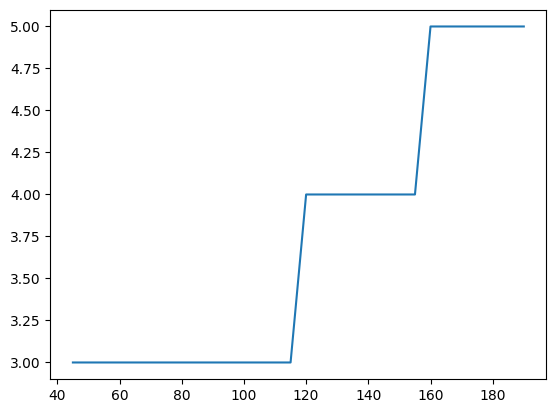

In [49]:
req_rate_v_n_data = np.array(req_rate_v_n_data)
plt.plot(req_rate_v_n_data.T[0], req_rate_v_n_data.T[1])    

### To Do
* correlations between client and server metrics
* what parameters to scan with more tests?
* how long is 10K transactions?